# **03 - Correlation Analysis and Visualization**

## Objectives

* Analyze relationships between house attributes and the target variable `SalePrice` to identify key predictors for modeling.
* Validate hypotheses by performing correlation analysis and visualizing the results.
* Generate insights through visualization such as heatmaps, scatterplots and boxplots to demonstrate the strength and direction of relationships.

## Inputs

* Cleaned dataset: `outputs/datasets/cleaned/house_prices_cleaned.csv`
* Hypotheses that can be found in [Hypotheses and Validation Process in README.md](LÄGG IN LÄNK!)

## Outputs

* Generate reusable code that answers **Business Requirement 1** by analyzing correlations and creating visualizations.
    * The code will also be used in the Streamlit app.
* Create and save data plots in `docs/plots` directory for use in Streamlit app.
* Identify and document the most relevant variables for the regression model based on the correlation analysis.

## Additional Comments

* The visualization in this notebook will also be used in the final dashboard to meet **Business Requirement 1**.

---

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues'

## Section 1: Load Data

Load the cleaned dataset from `outputs/datasets/cleaned/house_prices_cleaned.csv` into DataFrames and display the first five rows of the dataset.

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

## Section 2: Data Exploration

We create a data profiling report for exploratory data analysis (EDA) of the DataFrame `df`.

In [5]:
from ydata_profiling import ProfileReport

profile_report = ProfileReport(df=df, minimal=True)
profile_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Fix missing value for `GarageFinish` and check that no missing values remain.

In [6]:
df['GarageFinish'].fillna('None', inplace=True)

print(df['GarageFinish'].isnull().sum())

0


---

## Section 3: Correlation and PPS Analysis

Our dataset includes four categorical variables stored as `object` data types. To incorporate these variables into the correlation analysis, we use One Hot Encoding to convert them into numerical format.

In [7]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)

print(df_ohe.shape)
df_ohe.head(5)

(1460, 36)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,LotFrontage,...,BsmtFinType1_BLQ,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_None,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.0,706,150,548,2003.0,1710,8450,65.0,...,0,0,1,0,0,0,1,0,0,0
1,1262,0.0,3.0,978,284,460,1976.0,1262,9600,80.0,...,0,0,1,0,0,0,0,1,0,0
2,920,866.0,3.0,486,434,608,2001.0,1786,11250,68.0,...,0,0,1,0,0,0,1,0,0,0
3,961,0.0,3.0,216,540,642,1998.0,1717,9550,60.0,...,0,0,0,1,0,0,1,0,0,0
4,1145,0.0,4.0,655,490,836,2000.0,2198,14260,84.0,...,0,0,1,0,0,0,1,0,0,0


We define a set of functions to calculate and visualize the relationships between variables in the dataset. These functions generate heatmaps for correlation (Pearson and Spearman) and predictive power (PPS), offering insights into both linear, monotonic, and non-linear relationships. To maintain a clean and focused output, we suppress `FutureWarning` messages, which are not critical to the analysis but may clutter the console. The code ensures that the `docs/plots` directory exists, creating it if necessary, so that all generated plots are saved in an organized manner for easy access and future use. For clarity, heatmaps hide values that are 0 or less than 0.2, providing a cleaner and more interpretable visualization.

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
import warnings
%matplotlib inline

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Theme
sns.set_theme(style="darkgrid")

# Check and create the folder to save plots
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")

# Define correlation heatmap
def correlation_heatmap(df, threshold=0.5, figsize=(12, 8), font_size=8, title="Correlation Heatmap", save_path=None):
    """
    Generates a heatmap using correlation, filtering out weak correlations.
    """
    if df.shape[1] > 1:  # Check for enough columns
        # Filter rows and columns with values below the threshold
        filtered_data = df.loc[(abs(df) >= threshold).any(axis=1), (abs(df) >= threshold).any(axis=0)]

        # Create a mask to hide the upper triangle and values that are 0
        mask = np.zeros_like(filtered_data, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[(abs(filtered_data) <= 0.2)] = True

        formatted_data = filtered_data.applymap(lambda x: round(x, 2) if abs(x) > 0.2 else 0)

        # Draw heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(
            formatted_data, 
            annot=True, 
            cmap=sns.color_palette("Spectral"),
            mask=mask, 
            annot_kws={"size": font_size}, 
            linewidths=0.5
        )
        plt.title(title)

        # Save heatmap
        if save_path:
            ensure_directory_exists(os.path.dirname(save_path))  # Ensure directory exists
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Heatmap saved to {save_path}")
        
        plt.show()

# Define PPS heatmap
def pps_heatmap(df, threshold=0.2, figsize=(12, 8), font_size=8, title="PPS Heatmap", save_path=None):
    """
    Generates a heatmap for PPS matrices, filtering out weak predictive scores.
    """
    if df.shape[1] > 1:  # Check for enough columns
        # Filter rows and columns with values under the threshold
        filtered_data = df.loc[(abs(df) >= threshold).any(axis=1), (abs(df) >= threshold).any(axis=0)]

        # Create a mask to hide values <= 0.2 and values that are exactly 0
        mask = np.zeros_like(filtered_data, dtype=bool)
        mask[abs(filtered_data) <= 0.2] = True 
        mask[filtered_data == 0] = True

        formatted_data = filtered_data.applymap(lambda x: round(x, 2) if abs(x) > 0.2 else 0)

        # Draw heatmap
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            formatted_data, 
            annot=True, 
            cmap=sns.color_palette("Spectral"),
            annot_kws={"size": font_size}, 
            linewidths=0.5,
            mask=mask
        )
        # Remove axis titles
        ax.set_xlabel('')
        ax.set_ylabel('')

        plt.title(title)

        # Save heatmap
        if save_path:
            ensure_directory_exists(os.path.dirname(save_path))  # Ensure directory exists
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Heatmap saved to {save_path}")
        
        plt.show()

### Correlation Analysis

We start by calculating the Pearson and Spearman correlations.

In [9]:
numeric_df = df.select_dtypes(include=[np.number])
spearman_corr = numeric_df.corr(method="spearman")
pearson_corr = numeric_df.corr(method="pearson")

Generate heatmaps for Spearman and Pearson methods, hiding values that are 0 or less than 0.2.

**Spearman heatmap**
Evaluate monotonic relationships


Heatmap saved to docs/plots/spearman_correlation_heatmap.png


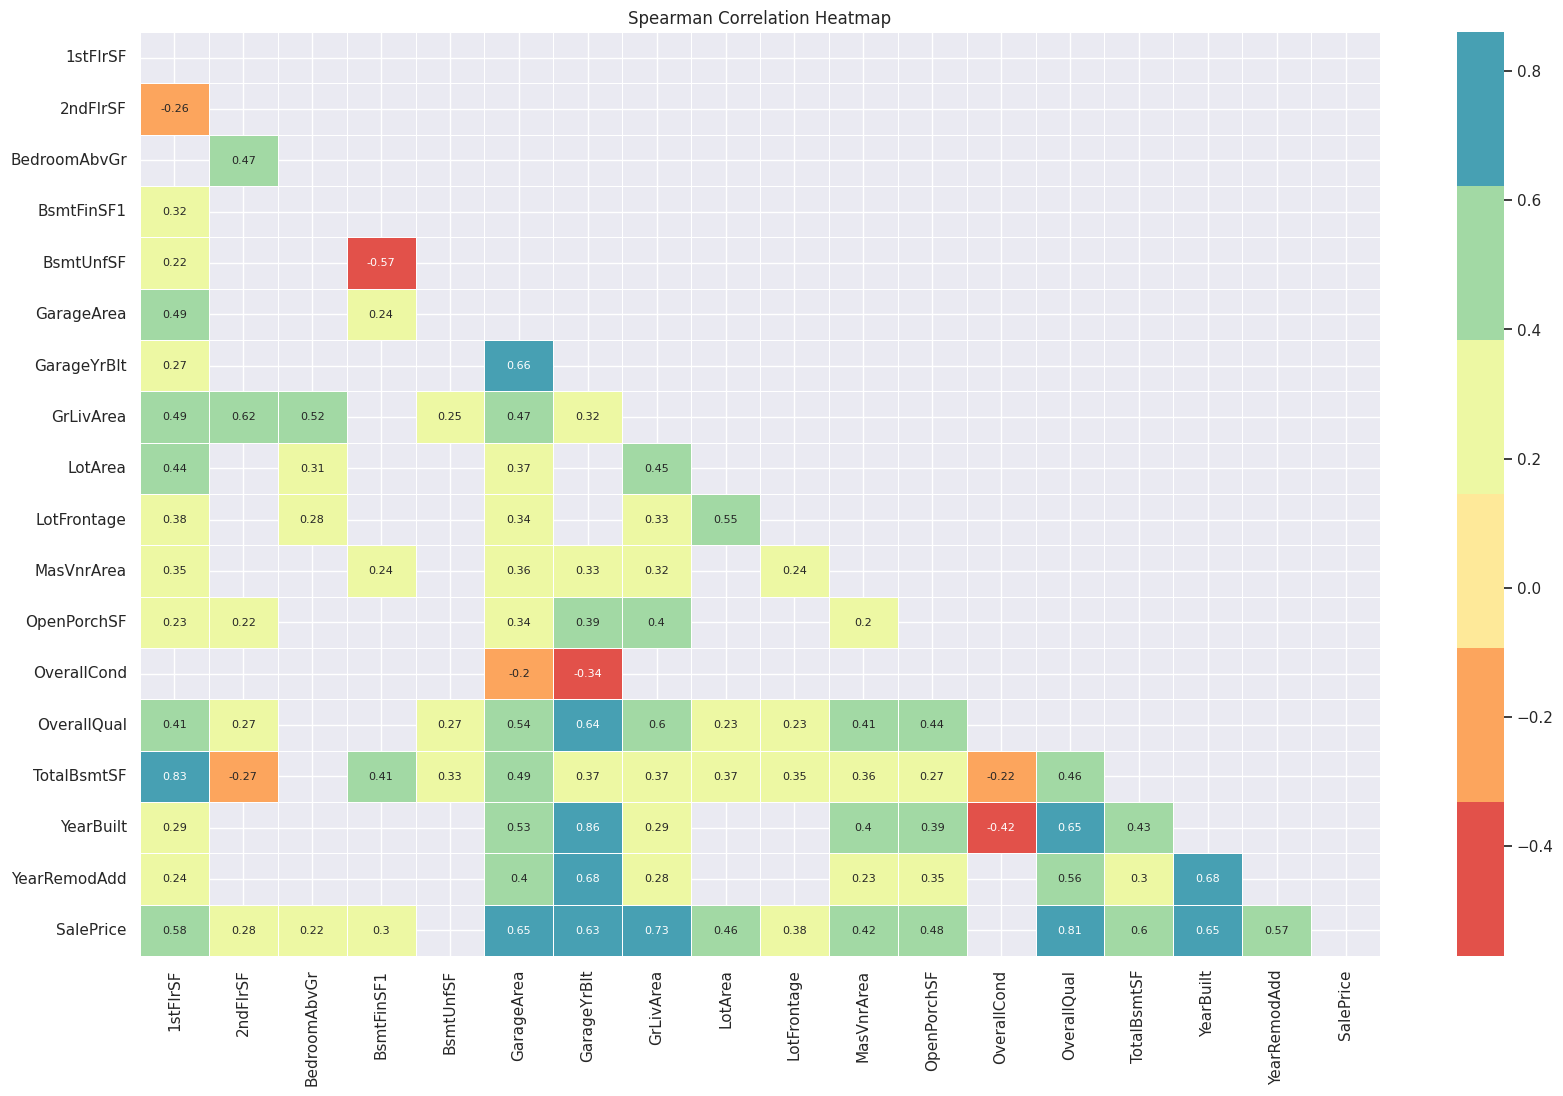

**Pearson heatmap**
Evaluate linear relationships
Heatmap saved to docs/plots/pearson_correlation_heatmap.png
Heatmap saved to docs/plots/pearson_correlation_heatmap.png


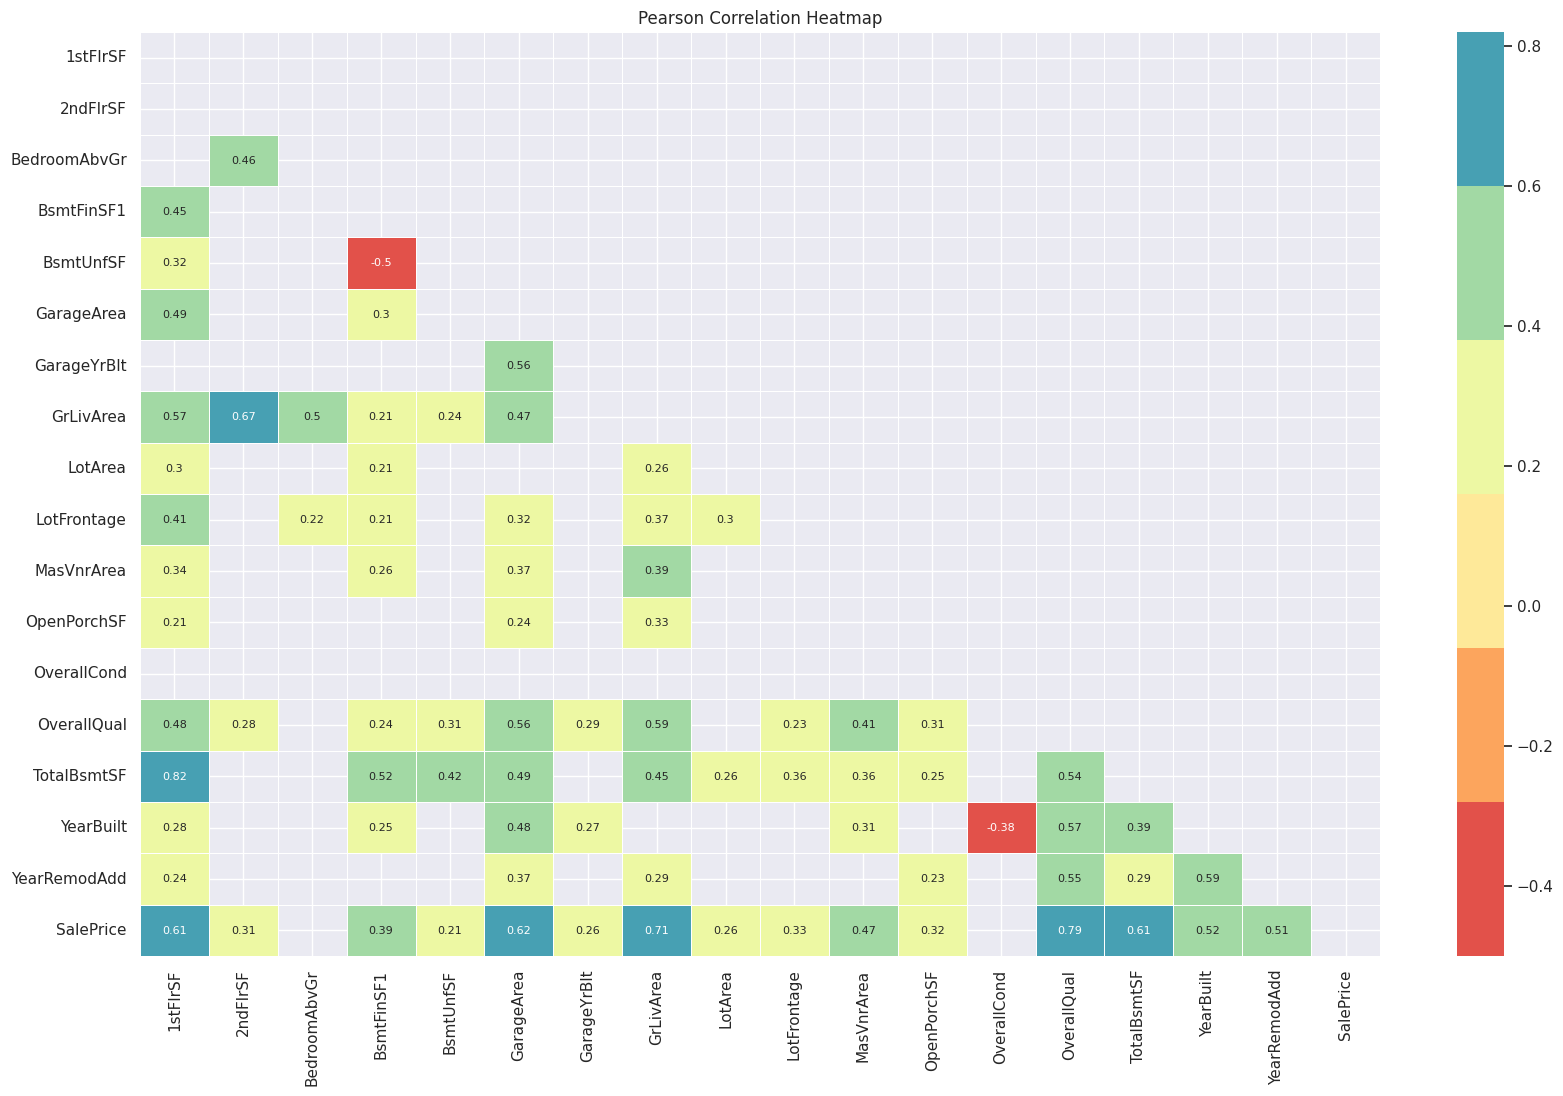

In [10]:
print("**Spearman heatmap**")
print("Evaluate monotonic relationships")
correlation_heatmap(
    df=spearman_corr,
    threshold=0.5,
    figsize=(20, 12),
    font_size=8,
    title="Spearman Correlation Heatmap",
    save_path="docs/plots/spearman_correlation_heatmap.png"
)
print("**Pearson heatmap**")
print("Evaluate linear relationships")
correlation_heatmap(
    df=pearson_corr,
    threshold=0.5,
    figsize=(20, 12),
    font_size=8,
    title="Pearson Correlation Heatmap",
    save_path="docs/plots/pearson_correlation_heatmap.png"
)

Calculates the Spearman correlation coefficients between the target variable `SalePrice` and all other columns in the `df_ohe` DataFrame, then sorts the results by absolute value in descending order, excluding the self-correlation of `SalePrice`.

In [11]:
spearman_corr = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
print("Top 10 Spearman correlations with SalePrice:")
spearman_corr.head(10)

Top 10 Spearman correlations with SalePrice:


OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
GarageYrBlt       0.634095
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
Name: SalePrice, dtype: float64

Calculates the Pearson correlation coefficients between the target variable `SalePrice` and all other columns in the `df_ohe` DataFrame, then sorts the results by absolute value in descending order, excluding the self-correlation of `SalePrice`.

In [12]:
pearson_corr = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
print("\nTop 10 Pearson correlations with SalePrice:")
print(pearson_corr.head(10))


Top 10 Pearson correlations with SalePrice:
OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64


Combine the top 10 attributes from Pearson and Spearman and create a list for further analysis.

In [13]:
top_n = 10
vars_to_study = list(set(pearson_corr.head(top_n).index.to_list() + spearman_corr.head(top_n).index.to_list()))

print("\nVariables selected for further study:")
print(vars_to_study)


Variables selected for further study:
['GarageYrBlt', 'GarageArea', 'KitchenQual_Ex', 'KitchenQual_Gd', 'YearRemodAdd', 'GrLivArea', 'YearBuilt', '1stFlrSF', 'TotalBsmtSF', 'MasVnrArea', 'OverallQual', 'KitchenQual_TA']


### PPS Matrix

Calculate PPS Matrix.

In [14]:
pps_matrix_raw = pps.matrix(df)
pps_matrix = pps_matrix_raw.pivot(index='y', columns='x', values='ppscore')

Show PPS statistics

In [15]:
pps_stats = pps_matrix_raw.query("ppscore < 1")['ppscore'].describe()
print("PPS Statistics:\n", pps_stats.round(3))

PPS Statistics:
 count    462.000
mean       0.056
std        0.106
min        0.000
25%        0.000
50%        0.000
75%        0.066
max        0.891
Name: ppscore, dtype: float64


Generate heatmap for PPS Matrix, hiding values that are 0 or less than 0.2 and save plot to `docs/plots`.

*** PPS Matrix Heatmap ***
To detect both linear and non-linear relationships.
Heatmap saved to docs/plots/pps_heatmap.png
Heatmap saved to docs/plots/pps_heatmap.png


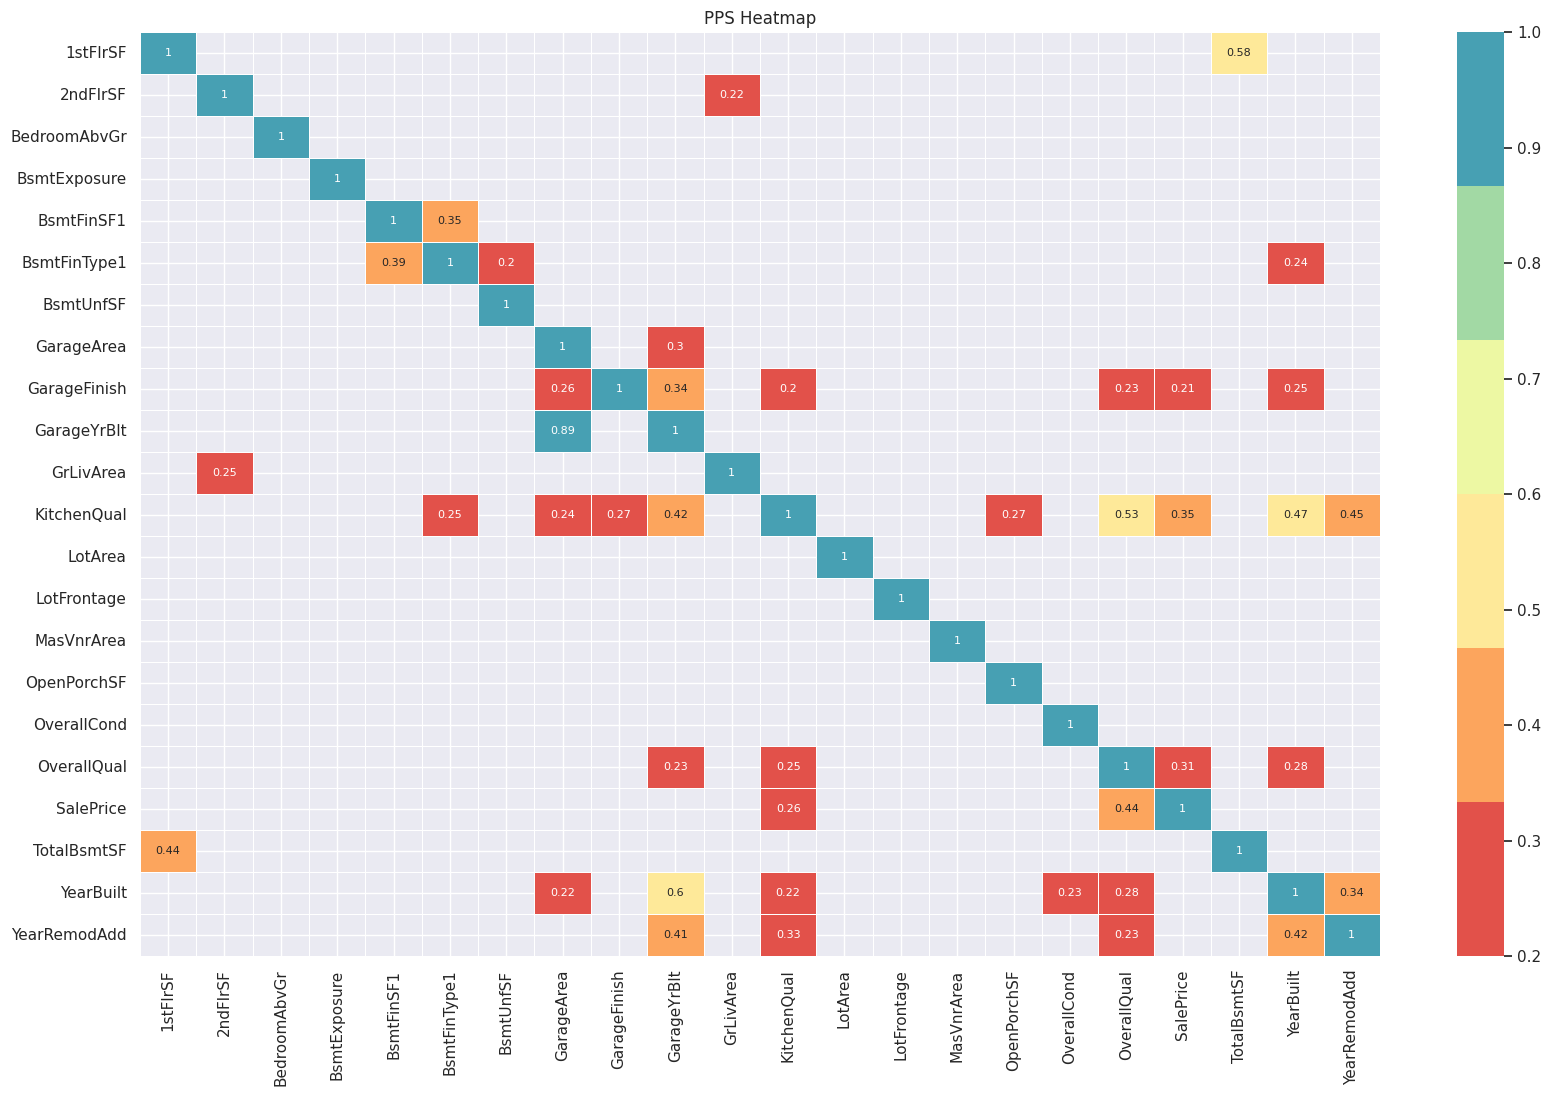

In [16]:
print("*** PPS Matrix Heatmap ***")
print("To detect both linear and non-linear relationships.")
pps_heatmap(
    df=pps_matrix,
    threshold=0.2,
    figsize=(20, 12),
    font_size=8,
    title="PPS Heatmap",
    save_path="docs/plots/pps_heatmap.png"
)

---

## Section 4: Exploratory Data Analysis (EDA) on selected variables.

Combine the top 10 variables from Pearson and Spearman.

In [17]:
top_n = 10
vars_to_study = set(
    pearson_corr.head(top_n).index.to_list() +
    spearman_corr.head(top_n).index.to_list()
)

print("\nCombined top 10 variables for further analysis:")
vars_to_study


Combined top 10 variables for further analysis:


{'1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

We create a new DataFrame (`df_eda`) containing the top attributes along with the target variable `SalePrice`. This makes it easier to use these variables in further analysis or modeling.

In [18]:
selected_features = list(vars_to_study) + ['SalePrice']
df_eda = df_ohe[selected_features]

df_eda.head()

,GarageYrBlt,GarageArea,KitchenQual_Ex,KitchenQual_Gd,YearRemodAdd,GrLivArea,YearBuilt,1stFlrSF,TotalBsmtSF,MasVnrArea,OverallQual,KitchenQual_TA,SalePrice
0,2003.0,548,0,1,2003,1710,2003,856,856,196.0,7,0,208500
1,1976.0,460,0,0,1976,1262,1976,1262,1262,0.0,6,1,181500
2,2001.0,608,0,1,2002,1786,2001,920,920,162.0,7,0,223500
3,1998.0,642,0,1,1970,1717,1915,961,756,0.0,7,0,140000
4,2000.0,836,0,1,2000,2198,2000,1145,1145,350.0,8,0,250000


We need to understand the distribution of the target variable (`SalePrice`) and identify whether it is skewed or contains outliers. This is important because skewness or outliers can affect the performance of predictive models.

We create a histogram with a KDE (Kernel Density Estimate) overlay to visualize the distribution of `SalePrice`.

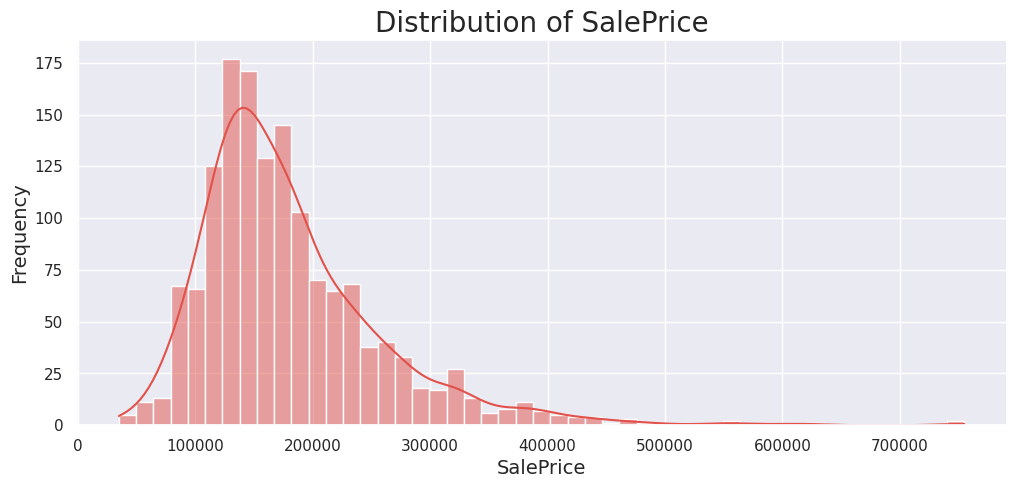

In [19]:
def plot_target_hist(df, target_var):
    """
    Function to plot a histogram of the target variable with KDE overlay.
    """
    plt.figure(figsize=(12, 5))
    sns.histplot(
        data=df,
        x=target_var,
        kde=True,
        color=sns.color_palette("Spectral")[0]
    )
    plt.title(f"Distribution of {target_var}", fontsize=20)
    plt.xlabel(target_var, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.savefig(f'docs/plots/hist_plot_{target_var}.png', bbox_inches='tight')        
    plt.show()

# Analyze the distribution of SalePrice
plot_target_hist(df_eda, 'SalePrice')

To address **Business Requirement 1**, which is to discover how house attributes correlate with the sale price. This involves performing a bivariate analysis to examine the relationship between each variable in `vars_to_study` and the target variable `SalePrice`.

We create three types of visualizations, which help us answer **Business Requirement 1**:
* **Linear regression plots** for continuous variables.
* **Boxplots** for categorical variables.
* **Line plots** for time variables.

The function `create_visualizations` automates the process of visualization by iterating through all variables in `vars_to_study` and selecting the appropriate visualization based on the variable type.

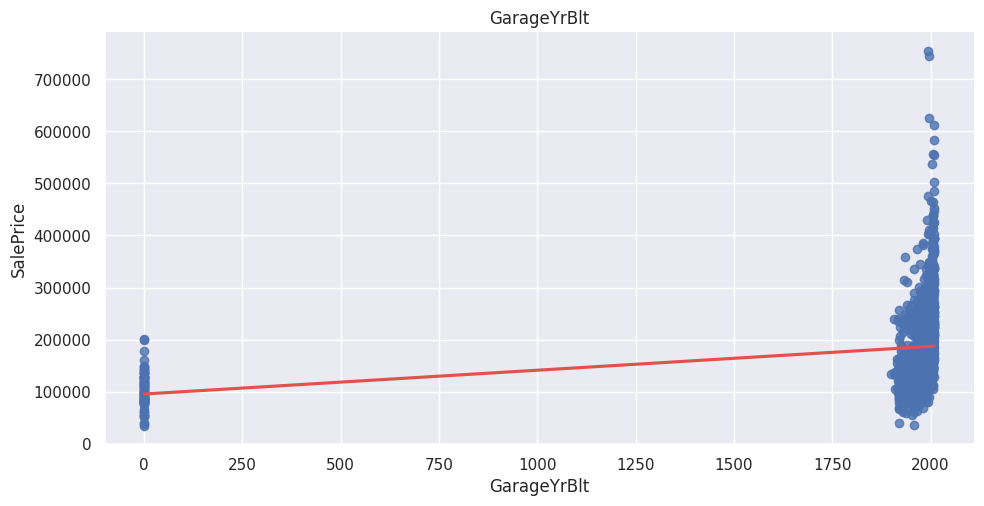

Linear regression plot created for GarageYrBlt




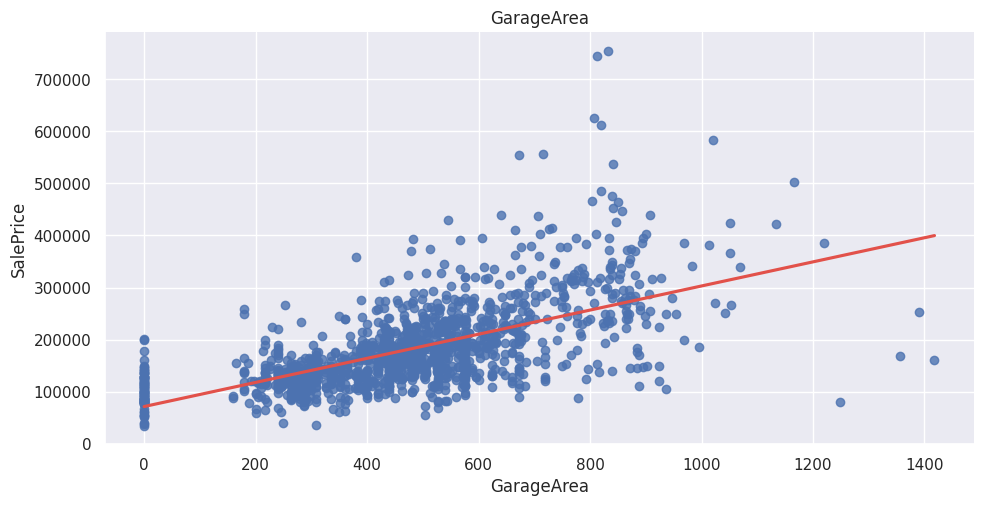

Linear regression plot created for GarageArea




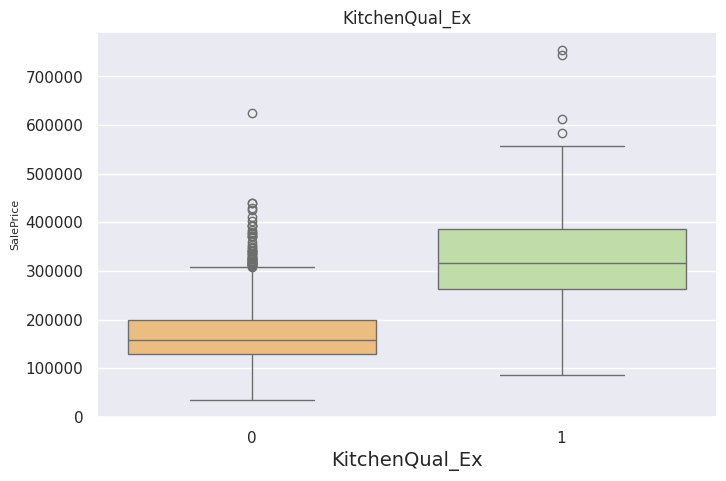

Boxplot created for KitchenQual_Ex




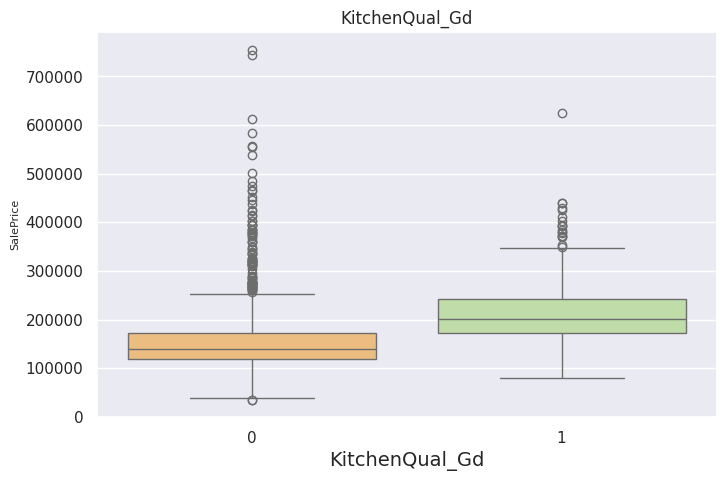

Boxplot created for KitchenQual_Gd




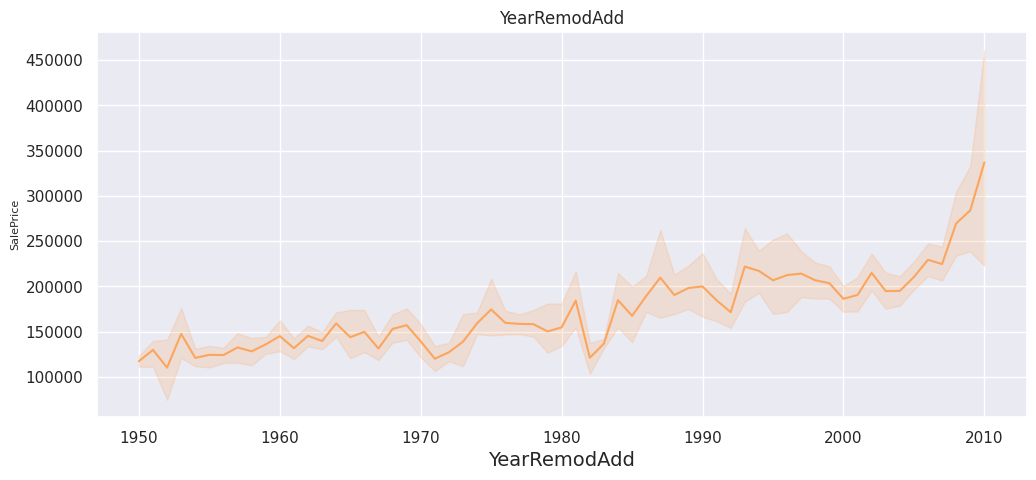

Line plot created for YearRemodAdd




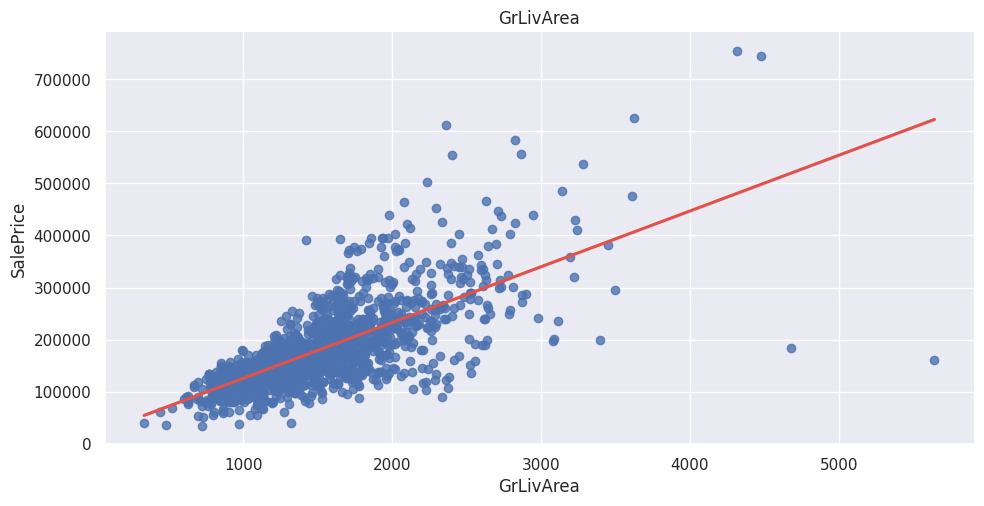

Linear regression plot created for GrLivArea




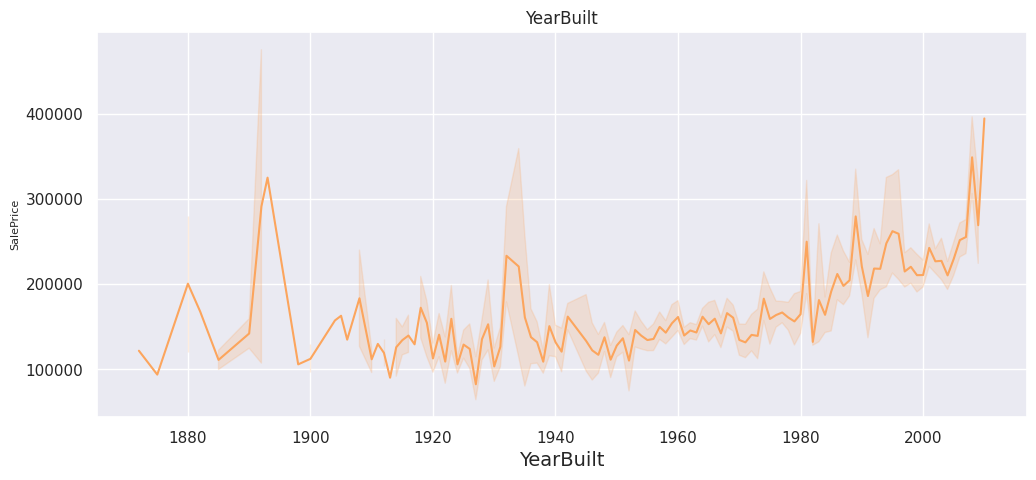

Line plot created for YearBuilt




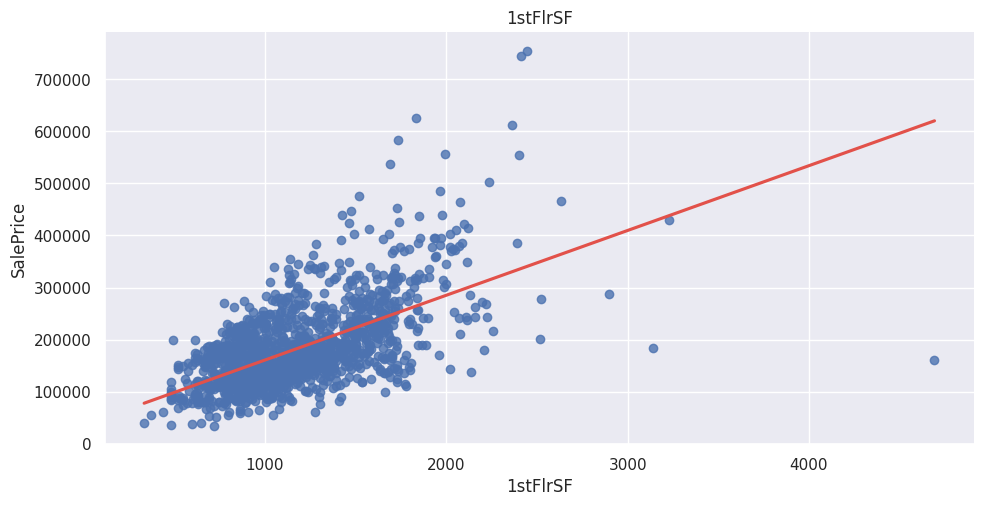

Linear regression plot created for 1stFlrSF




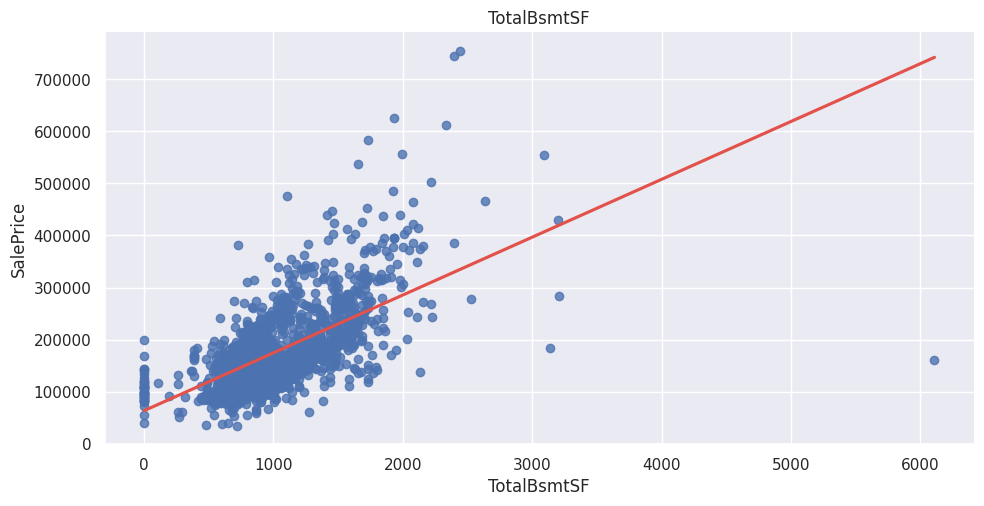

Linear regression plot created for TotalBsmtSF




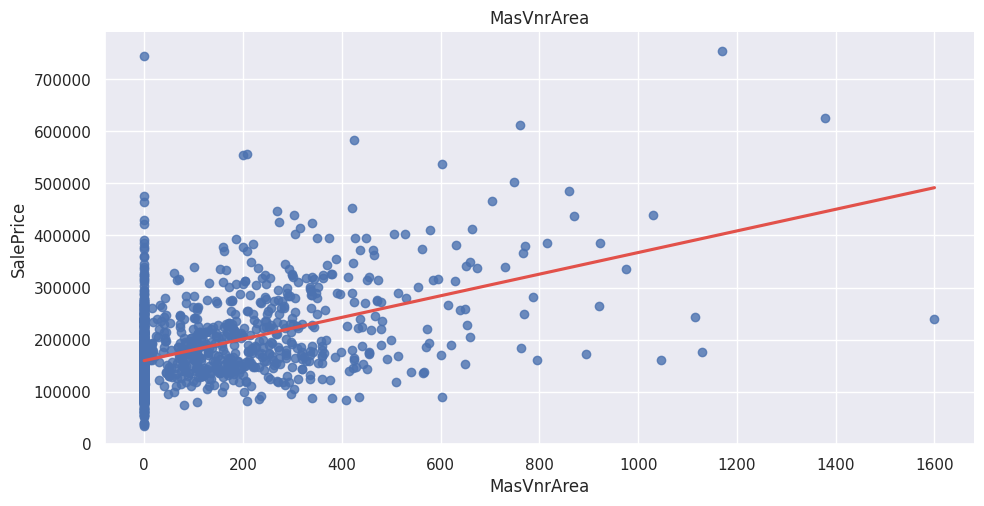

Linear regression plot created for MasVnrArea




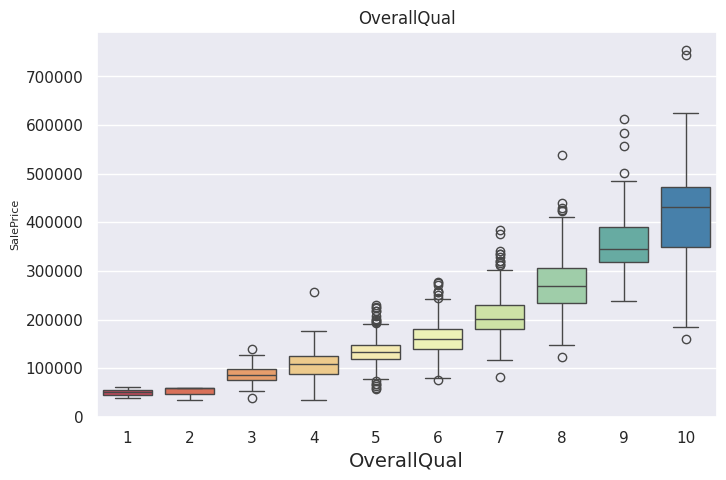

Boxplot created for OverallQual




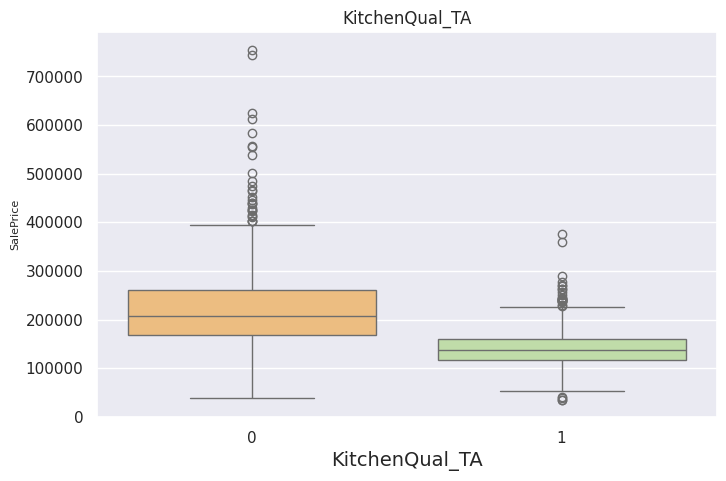

Boxplot created for KitchenQual_TA




In [20]:
sns.set_style('darkgrid')

# Time variables
time = ['YearBuilt', 'YearRemodAdd']

def plot_lm(df, col, target_var):
    """
    Function to create linear regression plots for continuous variables.
    """
    sns.lmplot(
        data=df, 
        x=col, 
        y=target_var, 
        ci=None, 
        line_kws={'color': sns.color_palette("Spectral")[0]}, 
        height=5, 
        aspect=2
    )
    plt.title(f"{col}", fontsize=12)
    plt.savefig(f'docs/plots/lm_plot_price_by_{col}.png', bbox_inches='tight')        
    plt.show()

def plot_box(df, col, target_var):
    """
    Function to create box plots for categorical variables.
    Dynamically adjusts the palette based on the number of categories.
    """
    num_categories = len(df[col].unique()) 
    palette = sns.color_palette("Spectral", n_colors=num_categories)  

    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df, 
        x=col, 
        y=target_var, 
        palette=palette
    ) 
    plt.title(f"{col}", fontsize=12)
    plt.xlabel(col, fontsize=14)
    plt.ylabel(target_var, fontsize=8)
    plt.savefig(f'docs/plots/box_plot_price_by_{col}.png', bbox_inches='tight')
    plt.show()

def plot_line(df, col, target_var):
    """
    Function to create line plots for time variables.
    """
    plt.figure(figsize=(12, 5))
    sns.lineplot(
        data=df, 
        x=col, 
        y=target_var, 
        color=sns.color_palette("Spectral")[1] 
    )
    plt.title(f"{col}", fontsize=12)
    plt.xlabel(col, fontsize=14)
    plt.ylabel(target_var, fontsize=8)
    plt.savefig(f'docs/plots/line_plot_price_by_{col}.png', bbox_inches='tight')        
    plt.show()

# Loop for visualizations
def create_visualizations(df, vars_to_study, target_var):
    """
    Loop through variables and create appropriate visualizations.
    """
    for col in vars_to_study:
        if len(df[col].unique()) <= 10:  # Categorical variables
            plot_box(df, col, target_var)
            print(f"Boxplot created for {col}\n\n")
        elif col in time:  # Time variables
            plot_line(df, col, target_var)
            print(f"Line plot created for {col}\n\n")
        else:  # Continuous variables
            plot_lm(df, col, target_var)
            print(f"Linear regression plot created for {col}\n\n")

# Call the function to create visualizations
create_visualizations(df_eda, vars_to_study, 'SalePrice')

## Conclusions and Next Steps

### Conclusions
We successfully completed the correlation analysis and visualization process, identifying key predictors for modeling and validating hypotheses related to house prices.

#### Key observations include
1. **Size Matters**: Larger properties, as indicated by variables like `1stFlrSF`, `GrLivArea`, `TotalBsmtSF`, and `GarageArea`, are associated with higher sale prices.
2. **Time Matters**: Recently built houses (`YearBuilt`) and houses with recent remodels (`YearRemodAdd`) tend to have higher sale prices.
3. **Quality Matters**: Higher overall quality (`OverallQual`) and kitchen quality (`KitchenQual`) ratings are strongly correlated with higher sale prices.

All visualizations were saved in the `docs/plots` directory for further use in the Streamlit app and to meet **Business Requirement 1**.

### Next steps: Feature Engineering
1. **Handle outliers**: Identify and address outliers in key variables like `GrLivArea`, `TotalBsmtSF`, and `GarageArea` to improve model robustness.
2. **Transform Variables**: Apply log transformation to `SalePrice` and other skewed variables to enhance linearity.
3. **Create New Features**: Combine existing variables to create new features.
4. **Scale Data**: Standardize or normalize numerical variables to ensure consistent scaling for modeling.